# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

A dataset of 41187 records has been provided, the dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
# Loading all the libraries that we will need for this exercise.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder
import category_encoders as ce

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay

import plotly.express as px
import warnings
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Loading the information
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# First visualization of the information
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Analysis

In [4]:
# let's review null values
df.isnull().sum()
# we have 0 nulls in all the columns

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Categorical Features

In [5]:
# We distribute the features that we identify as Categorical features within nominal and ordinal and then process them
nominal_f_columns = ['job', 'marital', 'education', "contact", "poutcome", "default","housing", "loan"]
ordinal_f_columns = ['month', 'day_of_week'] 

In the columns housing, loan and default the "unknown" option could be replace with the most popular option before encoder it


In [6]:
print(df["housing"].value_counts());

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


In [7]:
print(df["loan"].value_counts());

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


In [8]:
print(df["default"].value_counts());

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


y
no     36548
yes     4640
Name: count, dtype: int64


Text(0.5, 1.0, 'Success')

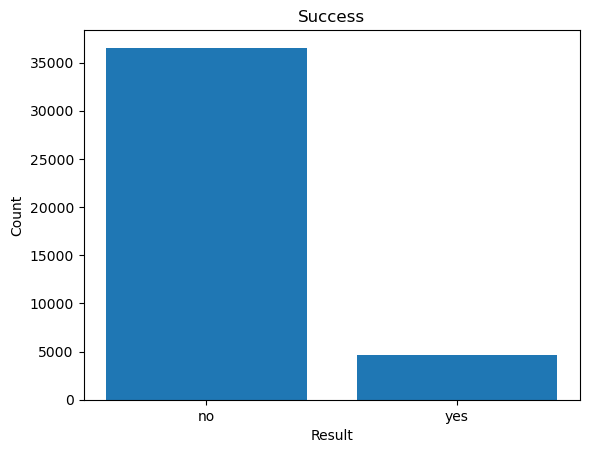

In [9]:
# Let's plot the initial information. Actually, this is an unbalanced data set.
# (8% success rate).
values_y = df["y"].value_counts()
print(values_y)
plt.bar(values_y.index, values_y.values)
plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Success")

In [10]:
# Convert Month feature to a pandas DataFrame order by month
values_month = df["month"].value_counts()
#values_month_plot
print(values_month)
data_months = {
    'month': ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov' , 'dec'],
    'value': [546, 2632, 13769, 5318, 7174, 6178, 570, 718, 4101, 182]
}

df_month = pd.DataFrame(data_months)
df_month

,month,value
0,mar,546
1,apr,2632
2,may,13769
3,jun,5318
4,jul,7174
5,aug,6178
6,sep,570
7,oct,718
8,nov,4101
9,dec,182


Text(0.5, 1.0, 'Success by Month')

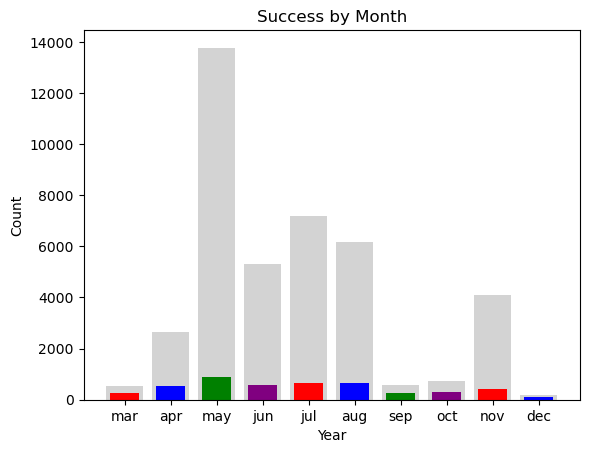

In [11]:
# vamos a remplazar
df["y"].replace({"yes": 1, "no":0}, inplace=True)

# After review the following plot we can conclude that success is most likely to occur in the 
# last month of each trimester (March, June, September and December)
df_grouped = df.groupby('month')['y'].sum().reset_index()

join_dataset = pd.merge(df_month, df_grouped, on='month', how='left')

fig, ax = plt.subplots()

# Colors
colors = ['red', 'blue', 'green', 'purple']

# plot main bars
bars = ax.bar(join_dataset['month'], join_dataset['value'], color='lightgray')

# Draw the marked bars above the main bars
for i, bar in enumerate(bars):
    if i < len(join_dataset):
        marcador_val = join_dataset['y'][i]
        # plot success bars
        ax.bar(bar.get_x() + bar.get_width() / 2, marcador_val, width=bar.get_width() * 0.8, color=colors[i % len(colors)], align='center')

# Labels
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Success by Month")

#### Conclusions first analysis

**1.** the objective value "y" could be changed to numerical "yes" = 1 and "no" = 0 <br>
**2.** In the columns housing, loan and default the "unknown" option could be replace with the most popular option before encoder it <br>
**3.** discard durations equals to 0 <br>
**4.** success is most likely to occur in the last month of each trimester (March, June, September and December)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective is to develop a model that can explain the success of a contact,
specifically whether the client subscribes to the deposit. this with the aim of increasing efficiency by identifying the key characteristics that influence success. helping in a better management of the available resources

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
# I am going to replace "yes" and "no" by 1 and 0
df["y"].replace({"yes": 1, "no":0}, inplace=True)
df["y"]

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [14]:
# discard durations equals to 0
df_cleaned= df[df["duration"]> 0]
print(len(df_cleaned))

41184


Replace the unkown for the most popular option for housing, loan and default.

In [15]:
print(df_cleaned["housing"].value_counts());
df_cleaned["housing"] = df_cleaned["housing"].replace({"unknown": "yes"})
print(df_cleaned["housing"].value_counts());

housing
yes        21573
no         18621
unknown      990
Name: count, dtype: int64
housing
yes    22563
no     18621
Name: count, dtype: int64


/var/folders/4g/zs3785952jg0jd5lfdn4s3sm0000gn/T/ipykernel_52711/1283759542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["housing"] = df_cleaned["housing"].replace({"unknown": "yes"})


In [16]:
print(df_cleaned["loan"].value_counts());
df_cleaned["loan"] = df_cleaned["loan"].replace({"unknown": "no"})
print(df_cleaned["loan"].value_counts());

loan
no         33946
yes         6248
unknown      990
Name: count, dtype: int64


/var/folders/4g/zs3785952jg0jd5lfdn4s3sm0000gn/T/ipykernel_52711/921392955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["loan"] = df_cleaned["loan"].replace({"unknown": "no"})


loan
no     34936
yes     6248
Name: count, dtype: int64


In [17]:
print(df_cleaned["default"].value_counts());
df_cleaned["default"] = df_cleaned["default"].replace({"unknown": "no"})
print(df_cleaned["default"].value_counts());

default
no         32584
unknown     8597
yes            3
Name: count, dtype: int64
default
no     41181
yes        3
Name: count, dtype: int64


/var/folders/4g/zs3785952jg0jd5lfdn4s3sm0000gn/T/ipykernel_52711/2734731226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["default"] = df_cleaned["default"].replace({"unknown": "no"})


In [18]:
# ENCODE NOMINAL FEATURES With target Encoder
encoder = TargetEncoder()
encoder_nominal = encoder.fit_transform(df[nominal_f_columns], df['y'])
encoder_nominal

,job,marital,education,contact,poutcome,default,housing,loan
0,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402
1,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402
2,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402
3,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402
4,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315
...,...,...,...,...,...,...,...,...
41183,0.252326,0.101573,0.113485,0.147376,0.088322,0.12879,0.116194,0.113402
41184,0.068943,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402
41185,0.252326,0.101573,0.137245,0.147376,0.088322,0.12879,0.116194,0.113402
41186,0.108260,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402


In [19]:
pd_processeced_nominal = pd.DataFrame(encoder_nominal, columns=nominal_f_columns, index = df.index)
pd_processeced_nominal

,job,marital,education,contact,poutcome,default,housing,loan
0,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402
1,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402
2,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402
3,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402
4,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315
...,...,...,...,...,...,...,...,...
41183,0.252326,0.101573,0.113485,0.147376,0.088322,0.12879,0.116194,0.113402
41184,0.068943,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402
41185,0.252326,0.101573,0.137245,0.147376,0.088322,0.12879,0.116194,0.113402
41186,0.108260,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402


In [20]:
# remove nominal columns and replace with encode value
df_cleaned = pd.concat([df.drop(columns=nominal_f_columns), pd_processeced_nominal], axis=1)
df_cleaned

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,nr.employed,y,job,marital,education,contact,poutcome,default,housing,loan
0,56,may,mon,261,1,999,0,1.1,93.994,-36.4,...,5191.0,0,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402
1,57,may,mon,149,1,999,0,1.1,93.994,-36.4,...,5191.0,0,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402
2,37,may,mon,226,1,999,0,1.1,93.994,-36.4,...,5191.0,0,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402
3,40,may,mon,151,1,999,0,1.1,93.994,-36.4,...,5191.0,0,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402
4,56,may,mon,307,1,999,0,1.1,93.994,-36.4,...,5191.0,0,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,nov,fri,334,1,999,0,-1.1,94.767,-50.8,...,4963.6,1,0.252326,0.101573,0.113485,0.147376,0.088322,0.12879,0.116194,0.113402
41184,46,nov,fri,383,1,999,0,-1.1,94.767,-50.8,...,4963.6,0,0.068943,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402
41185,56,nov,fri,189,2,999,0,-1.1,94.767,-50.8,...,4963.6,0,0.252326,0.101573,0.137245,0.147376,0.088322,0.12879,0.116194,0.113402
41186,44,nov,fri,442,1,999,0,-1.1,94.767,-50.8,...,4963.6,1,0.108260,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402


In [21]:
#Transformer Ordinal Features
oe_month = OrdinalEncoder(categories=[['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov' , 'dec']])
oe_week = OrdinalEncoder(categories=[['mon', 'tue', 'wed', 'thu', 'fri']])
ordinal_ohe_transformer = make_column_transformer(
    (oe_month, ['month']),
    (oe_week, ['day_of_week']),
    remainder='passthrough'
)

ordinal_processeced =ordinal_ohe_transformer.fit_transform(df_cleaned[ordinal_f_columns])
ordinal_processeced

array([[2., 0.],
       [2., 0.],
       [2., 0.],
       ...,
       [8., 4.],
       [8., 4.],
       [8., 4.]])

In [22]:
df_processed = pd.DataFrame(ordinal_processeced, columns=ordinal_f_columns, index=df.index)
df_processed

,month,day_of_week
0,2.0,0.0
1,2.0,0.0
2,2.0,0.0
3,2.0,0.0
4,2.0,0.0
...,...,...
41183,8.0,4.0
41184,8.0,4.0
41185,8.0,4.0
41186,8.0,4.0


In [120]:
# remove ordinal columns and replace with encode value
df_cleaned = pd.concat([df_cleaned.drop(columns=['month', 'day_of_week']), df_processed], axis=1)
df_cleaned

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job,marital,education,contact,poutcome,default,housing,loan,month,day_of_week
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402,2.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402,2.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.252326,0.101573,0.113485,0.147376,0.088322,0.12879,0.116194,0.113402,8.0,4.0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.068943,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402,8.0,4.0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.252326,0.101573,0.137245,0.147376,0.088322,0.12879,0.116194,0.113402,8.0,4.0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.108260,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402,8.0,4.0


In [24]:
# we can visualize our final data frame with which we are going to continue working
df_cleaned.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job,marital,education,contact,poutcome,default,housing,loan,month,day_of_week
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402,2.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402,2.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315,2.0,0.0


In [25]:
X = df_cleaned.drop(['y'], axis=True)
y = df_cleaned['y']

In [26]:
X

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,contact,poutcome,default,housing,loan,month,day_of_week
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.100000,0.101573,0.102490,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.081381,0.101573,0.108355,0.052313,0.088322,0.05153,0.108796,0.113402,2.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.116194,0.113402,2.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.129726,0.101573,0.082024,0.052313,0.088322,0.12879,0.108796,0.113402,2.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.081381,0.101573,0.108355,0.052313,0.088322,0.12879,0.108796,0.109315,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0.252326,0.101573,0.113485,0.147376,0.088322,0.12879,0.116194,0.113402,8.0,4.0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0.068943,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402,8.0,4.0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0.252326,0.101573,0.137245,0.147376,0.088322,0.12879,0.116194,0.113402,8.0,4.0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0.108260,0.101573,0.113485,0.147376,0.088322,0.12879,0.108796,0.113402,8.0,4.0


In [27]:
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [28]:
# We proceed to split our data set between train data and test data, the test data will be 20% of our total data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [121]:
# Use the DummyClassifier
dummy = DummyClassifier(strategy= "prior")

# fit the mdel 
dummy.fit(X_train, y_train)

# accuracy score
print("The accuracy of the dummy classifier for train data is {:.2%}".format(dummy.score(X_train, y_train)))
print("The accuracy of the dummy classifier for test data is {:.2%}".format(dummy.score(X_test, y_test)))

The accuracy of the dummy classifier for train data is 88.76%
The accuracy of the dummy classifier for test data is 88.65%


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [125]:
start_time = time.time()
log_r = LogisticRegression(max_iter=10000).fit(X_train, y_train)
train_time = time.time() - start_time

/Users/oscardominguez/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Problem 9: Score the Model

What is the accuracy of your model?

In [126]:
y_train_pred = log_r.predict(X_train)
y_test_pred = log_r.predict(X_test)

In [128]:
print("Accuracy_score the logistic regressor for train data is {:.2%}".format(accuracy_score(y_train_pred, y_train)))
print("Accuracy_score the logistic regressor for test data is {:.2%}".format(accuracy_score(y_test_pred, y_test)))

Accuracy_score the logistic regressor for train data is 90.92%
Accuracy_score the logistic regressor for test data is 91.04%


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

We create all the pipelines with the models with the default parameters

In [34]:
# basic pipeline with standard scaler for LR
pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

In [35]:
# basic pipeline with standard scaler for KNeighborsClassifier
pipe_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [36]:
# basic pipeline with standard scaler for SVC
pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

In [37]:
# basic pipeline with standard scaler for DecisionTreeClassifier
pipe_decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('d_tree', DecisionTreeClassifier())
])

In [38]:
classifiers = {
    'Logistic Regression': pipe_logistic,
    'KNN': pipe_KNN,
    'SVM': pipe_SVC,
    'Decision Tree': pipe_decision_tree
}

In [39]:
# this function evaluate the performance of multiple classifiers on training and test datasets, also store the training time
def calculate_scores(classifiers):
    results = []
    for name, clf in classifiers.items():
        start_time = time.time()
        clf.fit(X_train, y_train)
        fit_time = time.time() - start_time
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        results.append((name, train_score, test_score, fit_time))
    return results
results = calculate_scores(classifiers)
results

[('Logistic Regression',
  0.910773899848255,
  0.9090798737557659,
  0.10823702812194824),
 ('KNN', 0.925948406676783, 0.8986404467103666, 0.01030111312866211),
 ('SVM', 0.9197572078907436, 0.9081087642631707, 11.266582012176514),
 ('Decision Tree', 1.0, 0.8880796309783928, 0.12220907211303711)]

In [40]:
res_dict = {'Model': ['KNN', 'Logistic Regression', 'SVC', 'Decision Tree'],
           'Train Time': [results[1][3], results[0][3], results[2][3], results[3][3]],
           'Train Accuracy': [results[1][1], results[0][1], results[2][1], results[3][1]],
           'Test Accuracy': [results[1][2], results[0][2], results[2][2], results[3][2]],
           
           }
results_df = pd.DataFrame(res_dict).set_index('Model')
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
KNN,0.010301,0.925948,0.898640
Logistic Regression,0.108237,0.910774,0.909080
SVC,11.266582,0.919757,0.908109
Decision Tree,0.122209,1.000000,0.888080


* SVC is the classifier model that took the longest to train the data and the fastest model was KNN
* The model with the highest accuracy on the test data was LogisticRegression
* All models obtained greater precision than the reference model.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Engineeering

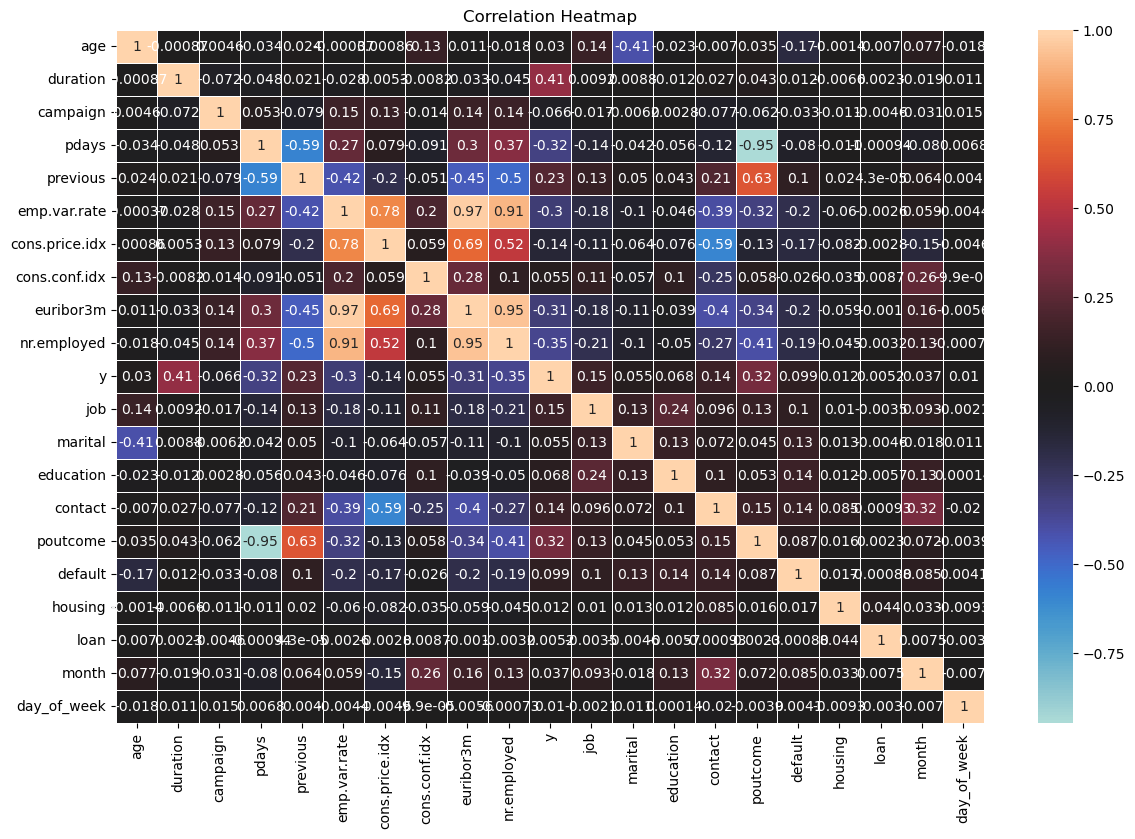

In [119]:
# To identify the influence of each feature linearly on the result, we make a plot of the correlations.
correlation_data = df_cleaned.corr()

#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 9))

sns.heatmap(correlation_data, center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

In [42]:
# Here we can identify that there are some features that are highly correlated with the resulting 
# variable such as: ['duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'poutcome'] 
# so I decided to work with these features.
cor_target = abs(correlation_data["y"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]
# Collect the names of the features
name_corr_features = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
name_corr_features.remove('y')

# Display the results
print(name_corr_features)


['duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'poutcome']


In [43]:
# I will try with Sequential Feature Selection
sfs = SequentialFeatureSelector(estimator = LogisticRegression(max_iter=10000),
                               scoring = "accuracy" ,
                               cv = 5,
                               n_features_to_select = 'auto')

sfs.fit(df_cleaned.drop('y', axis = 1), df_cleaned['y'])

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=10000),
                          scoring='accuracy')

In [44]:
sfs_names = sfs.get_feature_names_out(input_features=None)

In [45]:
sfs_names

array(['age', 'duration', 'campaign', 'pdays', 'marital', 'education',
       'poutcome', 'housing', 'loan', 'day_of_week'], dtype=object)

#### Hyperparameter tuning and grid search

For this test I will use the params that I got as the most correlated with the target feature

In [46]:
# Evaluate the performance of multiple classifiers on training and test datasets using grid search
def calculate_scores_grid_search(classifiers, features):
    results = []
    X_train_f = X_train[features]
    X_test_f = X_test[features]
    for name, clf in classifiers.items():
        start_time = time.time()
        clf.fit(X_train_f, y_train)
        fit_time = time.time() - start_time
        train_score = clf.best_estimator_.score(X_train_f, y_train)
        test_score = clf.best_estimator_.score(X_test_f, y_test)
        results.append((name, train_score, test_score, fit_time))
        print(results)
    return results

In [47]:
# Params and pipelines
param_grid_log = {
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [100, 200, 300,1000]  
}

pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

param_grid_knn = {
    'knn__n_neighbors': list(range(1, 20, 1)),
    'knn__weights': ['uniform'],
    'knn__p': [1, 2]
}

pipe_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid_svc = {'svc__kernel': ['rbf', 'poly', 'linear'],
         'svc__gamma': [0.1, 1.0]}

pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid_decision_tree = {
    'd_tree__max_depth': [None, 5, 10, 15, 20],
    'd_tree__min_samples_split': [2, 4,8,10],
    'd_tree__criterion': ['gini', 'entropy'],
    'd_tree__min_samples_leaf': [1, 2, 3]
}

pipe_decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('d_tree', DecisionTreeClassifier())
])

classifiers = {
    'Logistic Regression': GridSearchCV(estimator=pipe_logistic, param_grid=param_grid_log, cv=5),
    'KNN': GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_knn, cv=5),
    'SVM': GridSearchCV(estimator=pipe_SVC, param_grid=param_grid_svc, cv=5),
    'Decision Tree': GridSearchCV(estimator=pipe_decision_tree, param_grid=param_grid_decision_tree, cv=5)
}

In [48]:
# For this test I will use the params that I got as the most correlated with the target feature.
print(name_corr_features)
results = calculate_scores_grid_search(classifiers, name_corr_features)
# I am going to save in this comment the results for the calculate_score_grid_search function beacuase it took 2H
# results = [('Logistic Regression', 0.9085584218512899, 0.9088370963826171, 1.5207948684692383), ('KNN', 0.9192412746585736, 0.9107793153678078, 67.2934091091156), ('SVM', 0.9164795144157815, 0.9139354212187424, 7924.431136369705), ('Decision Tree', 0.9165098634294385, 0.9157562515173586, 23.365948915481567)]

['duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'poutcome']
[('Logistic Regression', 0.9085584218512899, 0.9088370963826171, 1.5207948684692383)]
[('Logistic Regression', 0.9085584218512899, 0.9088370963826171, 1.5207948684692383), ('KNN', 0.9192412746585736, 0.9107793153678078, 67.2934091091156)]
[('Logistic Regression', 0.9085584218512899, 0.9088370963826171, 1.5207948684692383), ('KNN', 0.9192412746585736, 0.9107793153678078, 67.2934091091156), ('SVM', 0.9164795144157815, 0.9139354212187424, 7924.431136369705)]
[('Logistic Regression', 0.9085584218512899, 0.9088370963826171, 1.5207948684692383), ('KNN', 0.9192412746585736, 0.9107793153678078, 67.2934091091156), ('SVM', 0.9164795144157815, 0.9139354212187424, 7924.431136369705), ('Decision Tree', 0.9165098634294385, 0.9157562515173586, 23.365948915481567)]


,Train Score,Test Score,Fit Time
Model,,,
KNN,0.925948,0.898640,0.010301
Logistic Regression,0.910774,0.909080,0.108237
SVC,0.919757,0.908109,11.266582
Decision Tree,1.000000,0.888080,0.122209


In [53]:
# final table
res_dict = {'Model': ['KNN', 'Logistic Regression', 'SVC', 'Decision Tree'],
           'Train Score': [results[1][1], results[0][1], results[2][1], results[3][1]],
           'Test Score': [results[1][2], results[0][2], results[2][2], results[3][2]],
           'Fit Time': [results[1][3], results[0][3], results[2][3], results[3][3]]
           }
results_df = pd.DataFrame(res_dict).set_index('Model')
results_df

,Train Score,Test Score,Fit Time
Model,,,
KNN,0.919241,0.910779,67.293409
Logistic Regression,0.908558,0.908837,1.520795
SVC,0.916480,0.913935,7924.431136
Decision Tree,0.916510,0.915756,23.365949


In [108]:
# Get the confusion matrix for the provided data
def plotConfusionMatrix(y_test_pred, y_test, display_labels = ['Not Subscribed', 'Subscribed'], title= ""):

    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.title(title)
    plt.show()

### Adjust your performance metric
I am going to add new scores to my current dataframe 

In [109]:
# params
# classifiers: object of grid search classfier methods
# classifier_name: name of the classification model that we want to evaluate with other metrics
# results Dataframe in where we are storing all the information
def add_new_metrics(classifiers, classifier_name, results):
    predicts = classifiers[classifier_name].best_estimator_.predict(X_test[name_corr_features])
    plotConfusionMatrix(predicts, y_test, ['Not Subscribed', 'Subscribed'], classifier_name)
    ps_knn = precision_score(y_test, predicts, zero_division=0)
    rc_knn = recall_score(y_test, predicts)
    f1_knn = f1_score(y_test, predicts)
    results.loc[classifier_name, "Precision Score Test"] = ps_knn
    results.loc[classifier_name, "Recall Score Test"] = rc_knn
    results.loc[classifier_name, "F1 Score Test"] = f1_knn
    return results;

#### KNN adding new scores

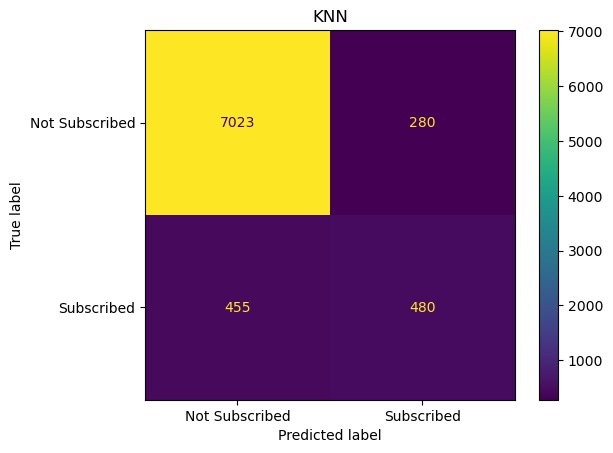

,Train Score,Test Score,Fit Time,Precision Score Test,Recall Score Test,F1 Score Test
Model,,,,,,
KNN,0.919241,0.910779,67.293409,0.631579,0.513369,0.566372
Logistic Regression,0.908558,0.908837,1.520795,0.666065,0.394652,0.495635
SVC,0.916480,0.913935,7924.431136,0.668155,0.480214,0.558805
Decision Tree,0.916510,0.915756,23.365949,0.675400,0.496257,0.572133


In [110]:
add_new_metrics(classifiers, "KNN", results_df)

#### Logistic Regression adding new scores

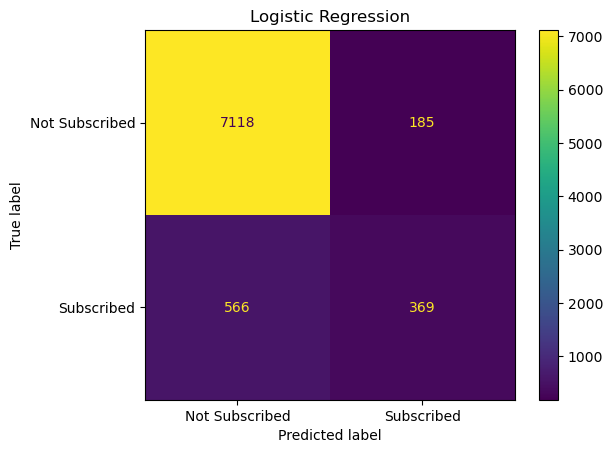

,Train Score,Test Score,Fit Time,Precision Score Test,Recall Score Test,F1 Score Test
Model,,,,,,
KNN,0.919241,0.910779,67.293409,0.631579,0.513369,0.566372
Logistic Regression,0.908558,0.908837,1.520795,0.666065,0.394652,0.495635
SVC,0.916480,0.913935,7924.431136,0.668155,0.480214,0.558805
Decision Tree,0.916510,0.915756,23.365949,0.675400,0.496257,0.572133


In [111]:
add_new_metrics(classifiers, "Logistic Regression", results_df)

#### Decision Tree adding new scores 

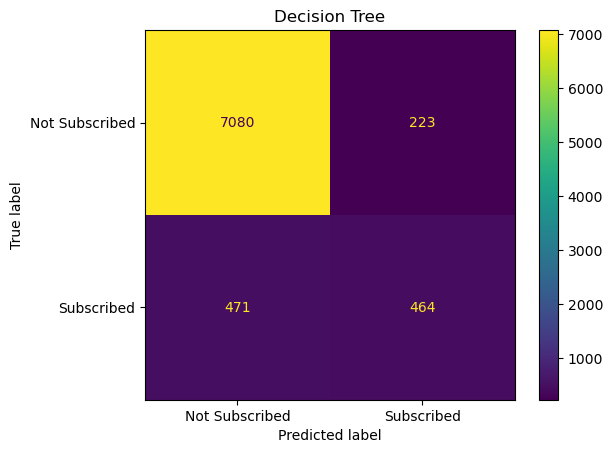

,Train Score,Test Score,Fit Time,Precision Score Test,Recall Score Test,F1 Score Test
Model,,,,,,
KNN,0.919241,0.910779,67.293409,0.631579,0.513369,0.566372
Logistic Regression,0.908558,0.908837,1.520795,0.666065,0.394652,0.495635
SVC,0.916480,0.913935,7924.431136,0.668155,0.480214,0.558805
Decision Tree,0.916510,0.915756,23.365949,0.675400,0.496257,0.572133


In [112]:
add_new_metrics(classifiers, "Decision Tree", results_df)

#### SVM Adding new Scores

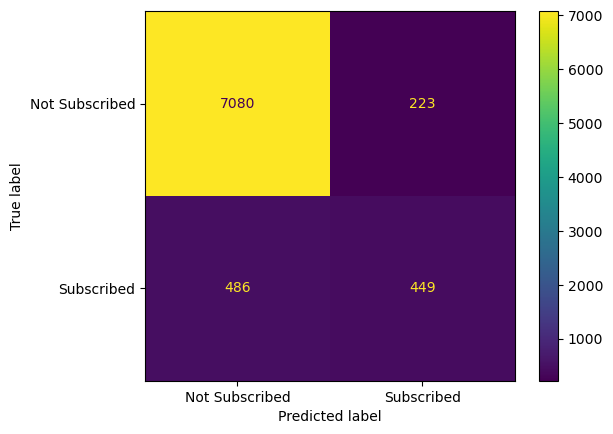

,Train Score,Test Score,Fit Time,Precision Score Test,Recall Score Test,F1 Score Test
Model,,,,,,
KNN,0.919241,0.910779,67.293409,0.631579,0.513369,0.566372
Logistic Regression,0.908558,0.908837,1.520795,0.666065,0.394652,0.495635
SVC,0.916480,0.913935,7924.431136,0.668155,0.480214,0.558805
Decision Tree,0.916510,0.915756,23.365949,0.675400,0.496257,0.572133


In [113]:
predicts = classifiers["SVM"].best_estimator_.predict(X_test[name_corr_features])
plotConfusionMatrix(predicts, y_test, ['Not Subscribed', 'Subscribed'])
ps_knn = precision_score(y_test, predicts, zero_division=0)
rc_knn = recall_score(y_test, predicts)
f1_knn = f1_score(y_test, predicts)
results_df.loc["SVC", "Precision Score Test"] = ps_knn
results_df.loc["SVC", "Recall Score Test"] = rc_knn
results_df.loc["SVC", "F1 Score Test"] = f1_knn
results_df

##### Questions